<a href="https://colab.research.google.com/github/lomurta/ProcImagens/blob/main/MedNIST_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de imagens com o conjunto de dados MedNIST

Introdução
Neste tutorial, apresentamos um exemplo de treinamento e avaliação de ponta a ponta com base no conjunto de dados MedNIST.
Passaremos pelos seguintes passos:

- Crie um conjunto de dados MONAI para treinamento e teste
- Use transformações MONAI para pré-processar dados
- Use o DenseNet do MONAI para a tarefa de classificação
- Treine o modelo com um programa PyTorch
- Avaliar no conjunto de dados de teste

### Obtenha o conjunto de dados
O conjunto de dados do MedNIST foi coletado de vários conjuntos do [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [o RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4) e o [conjunto de dados de raios-X do tórax do NIH](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).


Os comandos a seguir baixam e descompactam o conjunto de dados (~60 MB).

In [2]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

C:\Users\Lucas Miranda\AppData\Local\Temp\ipykernel_12660\2298874891.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  datafile.extractall()


#Instalando o MONAI

In [3]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 1.6.dev2524
Numpy version: 2.3.0
Pytorch version: 2.6.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1be81d981f92f8fa2fb1c27dfe5dad8c2e371624
MONAI __file__: C:\Users\<username>\AppData\Roaming\Python\Python312\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Numpy version: 2.3.0
Pytorch version: 2.6.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1be81d981f92f8fa2fb1c27dfe5dad8c2e371624
MONAI __file__: C:\Users\<username>\AppData\Roaming\Python\Python312\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.21.0+cu


##Lendo nomes de arquivos de imagem das pastas do conjunto de dados
Antes de mais nada, verifica os arquivos do conjunto de dados e mostra algumas estatísticas. Existem 6 pastas no conjunto de dados: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT, que devem ser usadas como rótulos para treinar nosso modelo de classificação.

In [2]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Visualizando alguns exemplos escolhidos aleatoriamente do conjunto de dados

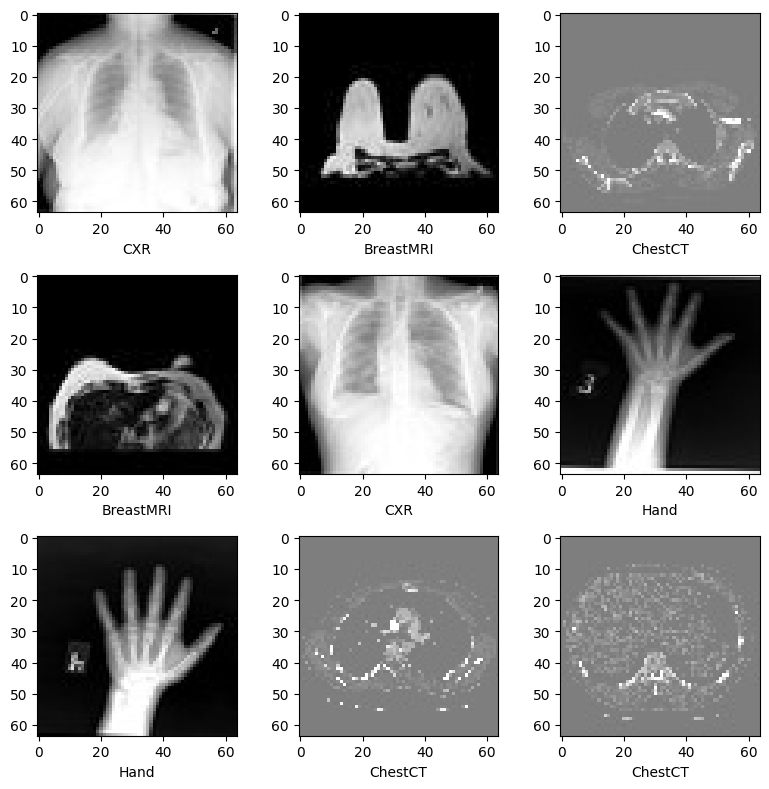

In [3]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Preparando listas de dados de treinamento, validação e teste
Selecionando aleatoriamente 10% do conjunto de dados como validação e 10% como teste.

In [4]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 47029 Validation count = 5952 Test count = 5973


## Definir transformações MONAI, Dataset e Dataloader para pré-processar os  dados de teste.

In [5]:
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

In [6]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=False)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, num_workers=0, pin_memory=False)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=128, num_workers=0)

## Definindo a rede e o otimizador
1. Definindo a taxa de aprendizado para o quanto o modelo é atualizado por lote.
2. Definindo o número de épocas total, pois misturamos sorteamos as transformações aleatórias, de modo que os dados de treinamento de cada época sejam diferentes.
E como este é apenas um tutorial de introdução, vamos treinar 4 épocas.
Se treinar 10 épocas, o modelo pode atingir 100% de precisão no conjunto de dados de teste.
3. Usando o DenseNet do MONAI e mude para o dispositivo GPU, este DenseNet pode suportar tarefas de classificação 2D e 3D.
4. Usando o otimizador Adam.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
epoch_num = 4
val_interval = 1

Using device: cuda:0



## Treinamento do modelo
Executa um treinamento típico do PyTorch que roda o laço de época e laço de passo, e faz a validação após cada época.
Salvará os pesos do modelo para arquivo se chegar à melhor acurácia de validação.

In [9]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Steps per epoch: {len(train_loader)}")

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Print progress every 10 steps instead of every step
        if step % 10 == 0 or step == len(train_loader):
            print(f"Step {step}/{len(train_loader)}, train_loss: {loss.item():.4f}")
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        print("Starting validation...")
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

Training dataset size: 47029
Validation dataset size: 5952
Batch size: 128
Steps per epoch: 368
----------
epoch 1/4
Step 10/368, train_loss: 0.1997
Step 10/368, train_loss: 0.1997
Step 20/368, train_loss: 0.1327
Step 20/368, train_loss: 0.1327
Step 30/368, train_loss: 0.1107
Step 30/368, train_loss: 0.1107
Step 40/368, train_loss: 0.0563
Step 40/368, train_loss: 0.0563
Step 50/368, train_loss: 0.1895
Step 50/368, train_loss: 0.1895
Step 60/368, train_loss: 0.0440
Step 60/368, train_loss: 0.0440
Step 70/368, train_loss: 0.0300
Step 70/368, train_loss: 0.0300
Step 80/368, train_loss: 0.0476
Step 80/368, train_loss: 0.0476
Step 90/368, train_loss: 0.0703
Step 90/368, train_loss: 0.0703
Step 100/368, train_loss: 0.0776
Step 100/368, train_loss: 0.0776
Step 110/368, train_loss: 0.0904
Step 110/368, train_loss: 0.0904
Step 120/368, train_loss: 0.0118
Step 120/368, train_loss: 0.0118
Step 130/368, train_loss: 0.0331
Step 130/368, train_loss: 0.0331
Step 140/368, train_loss: 0.0165
Step 140/3

## Plotando a perda e a métrica

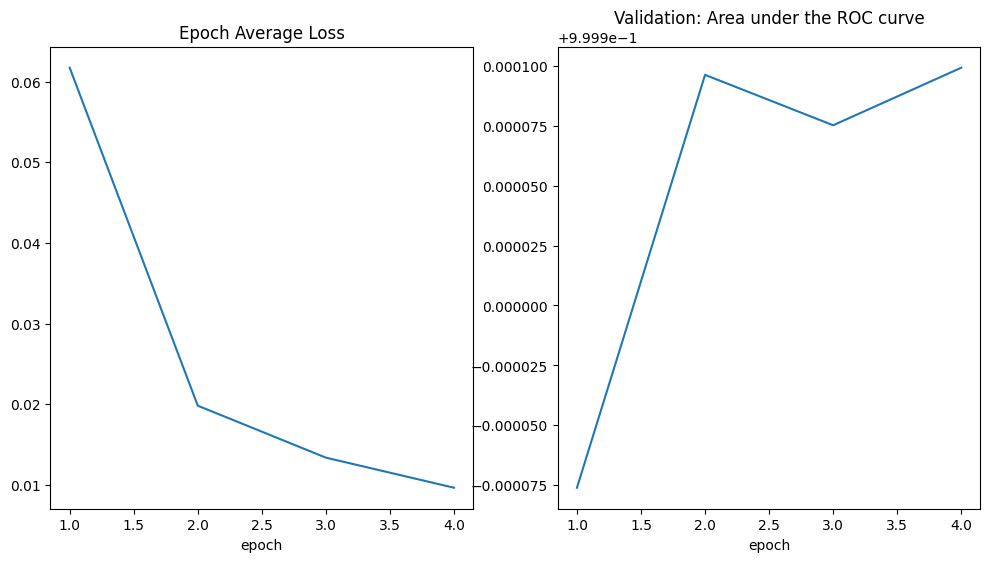

In [10]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Avaliando o modelo na base de dados de teste
Após treinamento e validação, já temos o melhor modelo no teste de validação.
Precisamos validar o modelo na base de dados de teste para checar se o modelo está robusto e não há over-fitting.
Usaremos estas predições para gerar um relatório de classificação.

In [11]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     1.0000    0.9980    0.9990      1024
   BreastMRI     1.0000    1.0000    1.0000       926
         CXR     1.0000    0.9990    0.9995      1015
     ChestCT     0.9970    1.0000    0.9985      1010
        Hand     1.0000    1.0000    1.0000      1005
      HeadCT     0.9990    0.9990    0.9990       993

    accuracy                         0.9993      5973
   macro avg     0.9993    0.9993    0.9993      5973
weighted avg     0.9993    0.9993    0.9993      5973

